In [840]:
words = open('names.txt', 'r').read().splitlines()

In [841]:
all_chars = sorted(set(''.join(words)))
stoi = {char: index + 1 for index, char in enumerate(all_chars)}
stoi['.'] = 0
itos = {index: char for char, index in stoi.items()}


In [842]:
import torch
import torch.nn.functional as F

N = torch.zeros((27, 27), dtype=torch.int32)

In [843]:
for word in words:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1


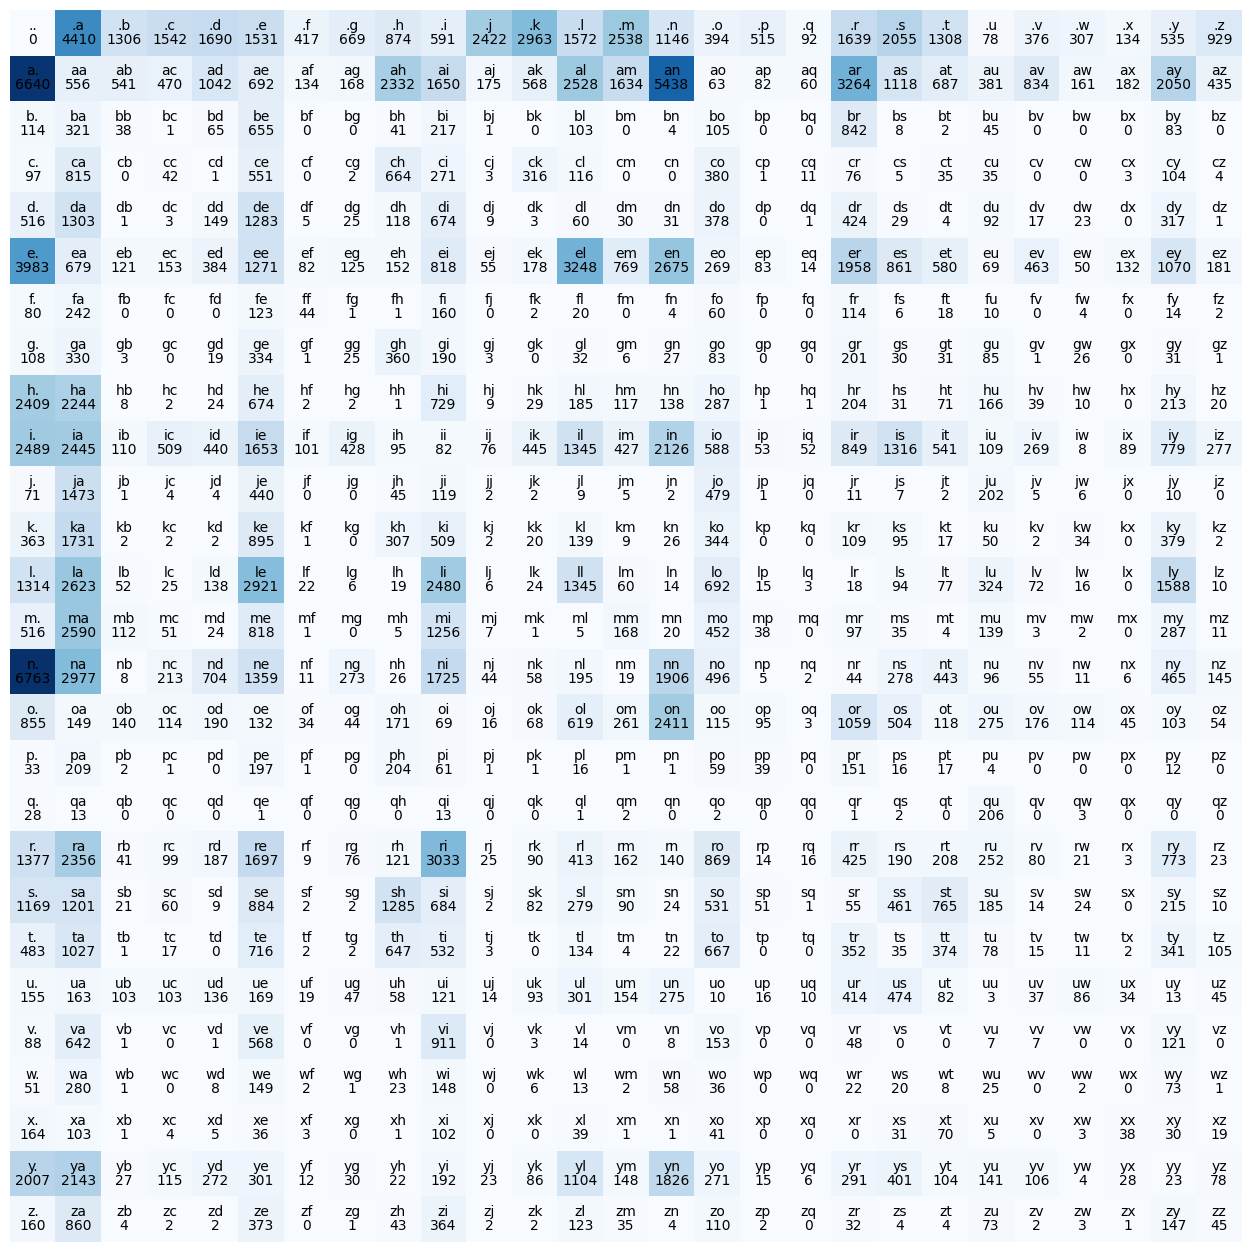

In [844]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='black')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='black')
plt.axis('off');

In [845]:
row = N[0].float()
row = row / row.sum()
row


tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [846]:
P = (N+1).float()
P /= P.sum(1, keepdims=True)

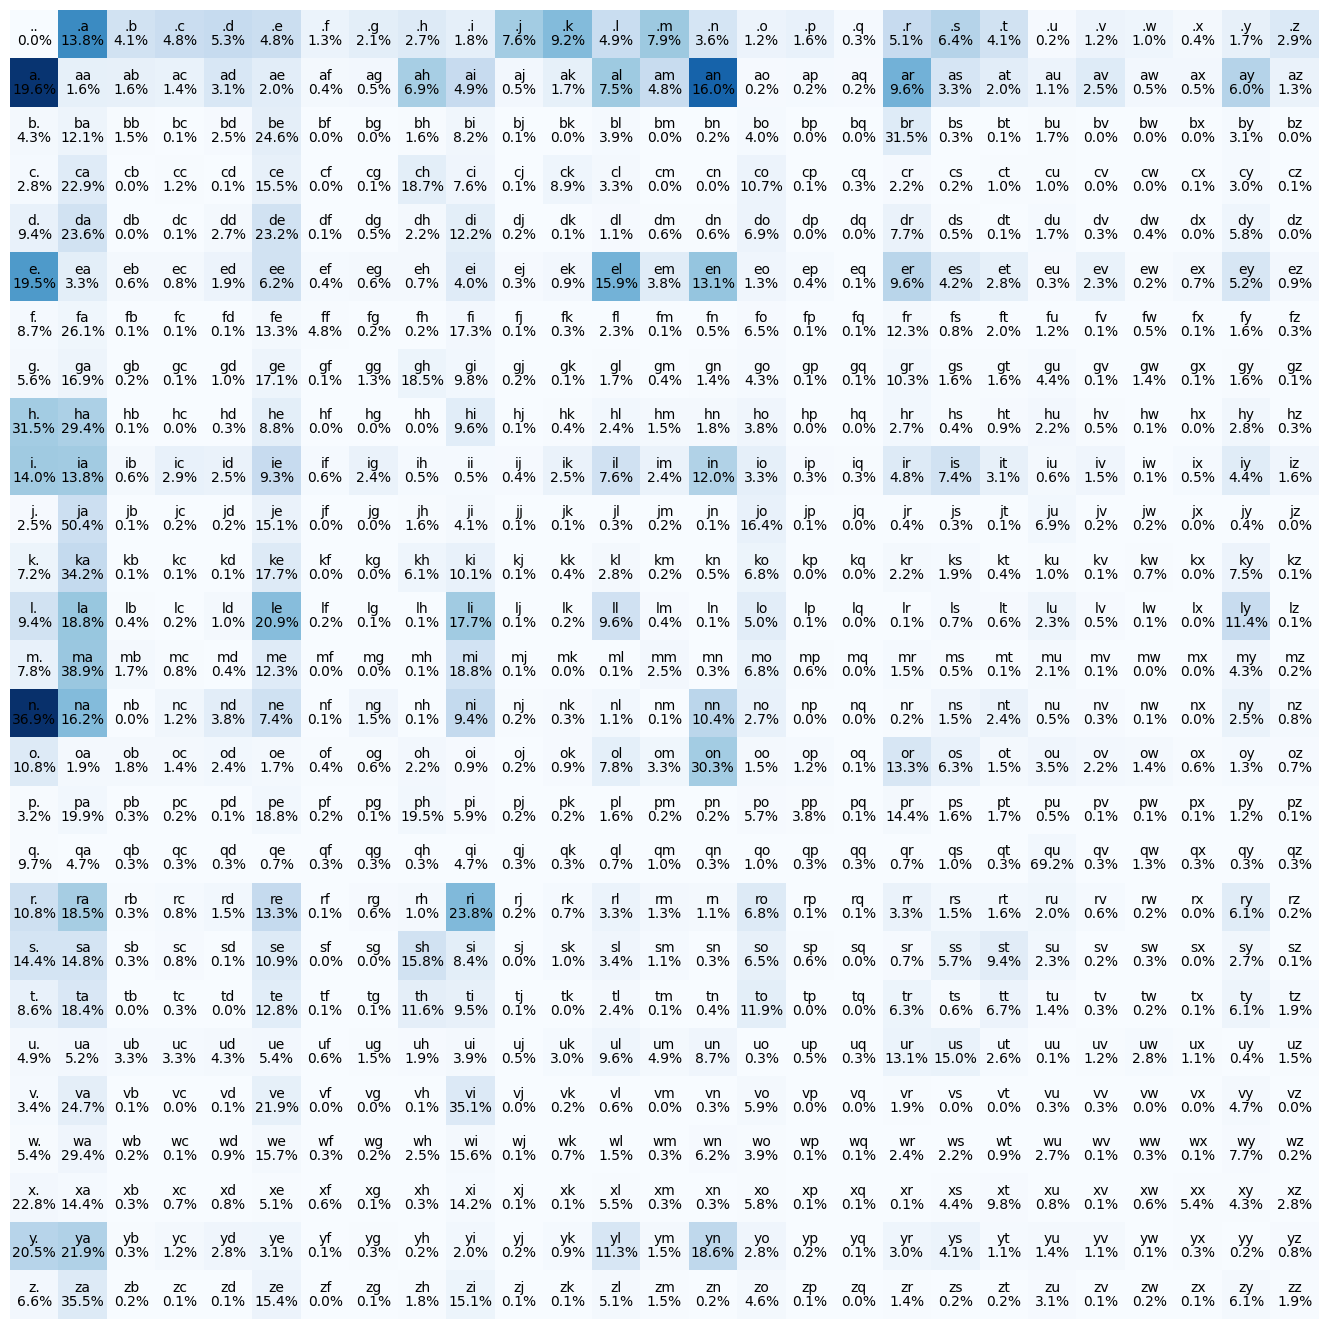

In [847]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(17,17))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='black')
        plt.text(j, i,  f'{P[i, j].item()*100:.1f}%' , ha="center", va="top", color='black')
plt.axis('off');

In [848]:
g = torch.Generator().manual_seed(545215215)

for _ in range(5):
    chari = 0
    output = []
    while True:
        row = P[chari]
        chari = torch.multinomial(row, num_samples=1, replacement=True, generator=g).item()
        output.append(itos[chari])
        if chari == 0:
            break
    print(''.join(output))


velore.
mija.
shaney.
liallm.
abulyan.


In [849]:
log_likelihood = 0.0
n = 0

for word in words:
    chars = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        probability = P[stoi[ch1], stoi[ch2]]
        probabilty_log = torch.log(probability)
        log_likelihood += probabilty_log
        n += 1
        # print(f'{ch1}{ch2} {probability}')

loss = -log_likelihood/n

print(f'{loss=}')

loss=tensor(2.4544)


In [850]:
g = torch.Generator().manual_seed(545215215)

inputs, desired_outputs = [], []

for word in words:
    chars = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        inputs.append(stoi[ch1])
        desired_outputs.append(stoi[ch2])

encoded_inputs = F.one_hot(torch.tensor(inputs), num_classes=27).float()
desired_outputs = torch.tensor(desired_outputs)
binom_num = desired_outputs.nelement()

# print(encoded_inputs)
# print(desired_outputs)


In [851]:
g = torch.Generator().manual_seed(545215215)

W = torch.randn((27, 27), generator=g, requires_grad=True)

In [852]:
a = encoded_inputs[0]
b = W[:,26]
print(a)
print(b)
a @ b

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([ 1.3569, -1.1347, -0.1031, -0.3902,  0.6577, -0.7234, -1.9026,  0.9187,
         0.2071, -0.0031, -1.0077,  0.7954, -0.3782,  0.3740,  0.6594, -1.6651,
        -1.0425, -1.5251, -0.0722,  1.2053,  0.7382, -1.3991,  1.1329, -1.3230,
        -0.3613,  0.9555, -0.2488], grad_fn=<SelectBackward0>)


tensor(1.3569, grad_fn=<DotBackward0>)

In [1056]:
# previous loss: 2.4544

for i in range(10):
    # foward pass
    logits = encoded_inputs @ W
    counts = logits.exp()
    probabilities = counts / counts.sum(1, keepdim=True)
    loss = -probabilities[torch.arange(binom_num), desired_outputs].log().mean()
    print(f'Loss: {loss.item()}')
    # backward pass
    W.grad = None
    loss.backward()

    # weights update
    W.data += -30 * W.grad

Loss: 2.4572393894195557
Loss: 2.4572343826293945
Loss: 2.4572293758392334
Loss: 2.4572243690490723
Loss: 2.457219362258911
Loss: 2.45721435546875
Loss: 2.457209348678589
Loss: 2.457204580307007
Loss: 2.4571995735168457
Loss: 2.4571943283081055


In [1057]:
g = torch.Generator().manual_seed(545215215)

for _ in range(5):
    chari = 0
    output = []
    while True:
        chari_encoded = F.one_hot(torch.tensor([chari]), num_classes=27).float()

        logits = chari_encoded @ W
        counts = logits.exp()
        probabilities = counts / counts.sum(1, keepdim=True)

        chari = torch.multinomial(probabilities, num_samples=1, replacement=True, generator=g).item()
        output.append(itos[chari])

        if chari == 0:
            break
    print(''.join(output))

# previous generation:
# velore.
# mija.
# shaney.
# liallm.
# abulyan.

velore.
mija.
shaney.
liallm.
abulyan.
